<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
<div hidden>
    $$
    \newcommand{\reals}{\mathbb{R}}
    \newcommand{\naturals}{\mathbb{N}}
    \newcommand{\integers}{\mathbb{Z}}
    \newcommand{\prob}{\mathbb{P}}
    \newcommand{\expect}{\mathbb{E}}
    \newcommand{\b}[1]{\mathbf{#1}}
    \newcommand{\bs}[1]{\boldsymbol{#1}}
    \newcommand{\c}[1]{\mathcal{#1}}
    \newcommand{mat}[2]{\left[\,\begin{array}{#1}#2\end{array}\,\right]}
    $$
</div>

# COMPSCI 371 Homework 3

_**Group Members:**_

### Problem 0 (3 points)

## Part 1: Stochastic Gradient Descent

In [1]:
import urllib.request
import ssl
from os import path as osp
import shutil


def retrieve(file_name, semester='fall24', homework=3):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        context = ssl._create_unverified_context()
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci371/homework/{}/{}'
        url = fmt.format(semester, homework, file_name)
        with urllib.request.urlopen(url, context=context) as response:
            with open(file_name, 'wb') as file:
                shutil.copyfileobj(response, file)
        print('Downloaded file {}'.format(file_name))

In [2]:
retrieve('helpers.py', homework=2)

Using previously downloaded file helpers.py


In [3]:
from helpers import Stepper
from autograd import numpy as anp
import numpy as snp


def gradient_descent(
    f, z, alpha, min_step=1.e-6, max_iter=10000, history=False, **kwargs
):
    step = Stepper(f, z, alpha, history=history, **kwargs)
    z, fz, gz = anp.copy(z), step.fz0, step.gz0
    for k in range(max_iter):
        s, z, fz, gz = step(z, **kwargs)
        if anp.linalg.norm(s) < min_step:
            break
    step.show_history()
    return fz, z, k

In [4]:
import pickle


file_name = 'students.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    students = pickle.load(file)

Using previously downloaded file students.pkl


In [5]:
print(students.features)
print(students.values)

['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
Performance Index


### Problem 1.1

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression

x_train = students.train.x
y_train = students.train.y
x_test = students.test.x
y_test = students.test.y

# Train the model
model = LinearRegression()
model.fit(x_train, y_train)

# Function to compute RMS
def rms(v, x, y):
    y_pred = model.predict(x)
    numerator = np.sqrt(np.mean((y - y_pred) ** 2))
    denominator = np.sqrt(np.mean(y ** 2))
    return numerator / denominator

print("Model coefficients:", model.coef_)
print("Model intercept:", model.intercept_)
print("Relative RMS error (Training): {:.4f}".format(rms(model.coef_, x_train, y_train)))
print("Relative RMS error (Testing): {:.4f}".format(rms(model.coef_, x_test, y_test)))


Model coefficients: [0.07365753 0.17634194 0.00817971 0.00533195]
Model intercept: 0.5523395643090314
Relative RMS error (Training): 0.0350
Relative RMS error (Testing): 0.0355


Performance: The relative RMS error on the training set was computed to be 0.0350, which indicates that the model fits the training data well. A relative RMS error of 0.0350 suggests that the residuals (the differences between the predicted and actual values) are small relative to the magnitude of the actual values.

Generalization: The similarity of the relative RMS error from the training set (0.0350) to the testing set (0.0355) indicates effective generalization. There's no significant increase or decrease in error when the model is applied to the test data. This means that the data is not overfitting nor underfitting. For example, if the model was overfitting, that is kind of just memorizing the training data, that would lead to a higher testing error. Also, we know the model is not underfitting since it reports a low, comparable test accuracy which wouldn't be the case if our model had high bias. Since the relative RMS errors of the training set and test set are both low and similar to each other, our model is generalizing well.

### Problem 1.2

In [10]:
def risk(v, x=None, y=None, indices=None):
    if indices is None:
        indices = range(len(y))  # Use the entire dataset if no indices are provided
    b = v[0]
    w = v[1:]
    predictions = b + anp.dot(x[indices], w)
    errors = predictions - y[indices]
    mean_squared_error = anp.mean(anp.square(errors))
    return mean_squared_error

b = 5
w = anp.array([1, 2, 3, 4])
v = anp.concatenate(([b], w))

x_train = students.train.x
y_train = students.train.y

print("Risk for the entire dataset: {:.4f}".format(risk(v, x_train, y_train)))
print("Risk for the first 100 samples: {:.4f}".format(risk(v, x_train, y_train, indices=range(100))))
print("Risk for the last 100 samples: {:.4f}".format(risk(v, x_train, y_train, indices=range(-100, 0))))


Risk for the entire dataset: 50.1153
Risk for the first 100 samples: 44.3617
Risk for the last 100 samples: 53.2272


### Problem 1.3

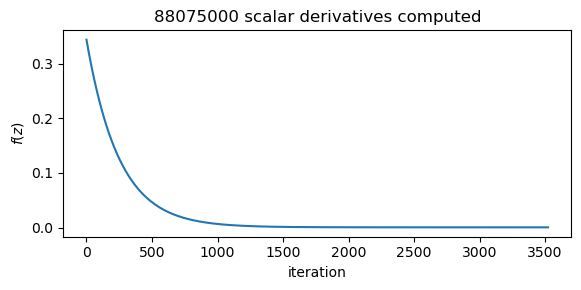

num epochs:  3521
v: [0.55186512 0.07362859 0.17619758 0.0081941  0.00536668]
Training RMS: 0.035038897495906655
Testing RMS: 0.0354565042741402


In [25]:
import numpy as snp  # Ensure standard numpy is imported
from autograd import numpy as anp  # For autograd.numpy
anp.random.seed(42)
# The risk function should correctly handle x and y passed as kwargs
def risk(v, x=None, y=None, indices=None):
    if indices is None:
        indices = range(len(y))  # Use the entire dataset if no indices are provided
    b = v[0]
    w = v[1:]
    predictions = b + anp.dot(x[indices], w)
    errors = predictions - y[indices]
    mean_squared_error = anp.mean(anp.square(errors))
    return mean_squared_error

# SGD function with corrected handling of x and y
def sgd(h, v, alpha=1.e-3, x=None, y=None, batch_size=None,
        min_step=1.e-6, max_epochs=5000, history=True):
    
    # Ensure batch_size is set, defaulting to full dataset if not specified
    batch_size = batch_size if batch_size else x.shape[0]

    # Initialize Stepper with the correct indices and batch data
    step = Stepper(h, v, alpha, indices=snp.arange(batch_size), history=history, x=x, y=y)
    
    v = anp.copy(v)
    num_batches = len(x) // batch_size

    num_epochs = 0
    prev_v = anp.copy(v)

    for k in range(max_epochs):
        num_epochs = k
        rng = np.random.default_rng(seed=42)
        ordering = rng.permutation(len(x))

        for i in range(num_batches):
            indices = ordering[i * batch_size : min((i + 1) * batch_size, len(x))]
            v = step(v, x=x, y=y, indices=indices)[1]

        if anp.linalg.norm(anp.array(prev_v) - anp.array(v)) < min_step:
            break

        prev_v = anp.copy(v)

    step.show_history()
    return v, num_epochs

# Example usage:
# Assuming students.train.x and students.train.y are defined and valid
v = anp.zeros(students.train.x.shape[1] + 1)  # Initialize v with zeros

# Run the SGD function
v, num_epochs = sgd(risk, v, x=students.train.x, y=students.train.y)

print("num epochs: ", num_epochs)
print("v:", v)
print("Training RMS:", rms(v, students.train.x, students.train.y))
print("Testing RMS:", rms(v, students.test.x, students.test.y))


### Problem 1.4 (Exam Style)

When batch_size=None in the SGD method, the entire dataset is used for each update, effectively reducing the stochastic gradient descent (SGD) to regular gradient descent (GD). In this setting, each update considers all data points, which is precisely what happens in regular gradient descent. Thus, SGD with batch_size=None is equivalent to gradient descent.

### Problem 1.5

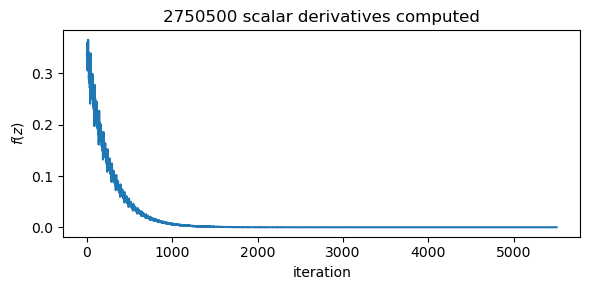

num epochs: 109
v: [0.55232602 0.07365547 0.17633033 0.0081905  0.00534347]
training: 0.035038897495906655
testing: 0.0354565042741402


In [27]:

v = anp.zeros(students.train.x.shape[1] + 1)  # Initialize v with zeros

v, num_epochs = sgd(risk, v, x=students.train.x, y=students.train.y, batch_size=100)
print("num epochs:", num_epochs)
print("v:", v)
print("training:",rms(v, students.train.x, students.train.y))
print("testing:",rms(v, students.test.x, students.test.y))

### Problem 1.6 (Exam Style)

Which of the two optimizations (Problem 1.3 or 1.5) required computing fewer scalar derivatives?


We should note that the number of scalar derivates per epoch for full-batch gradient descent is the same number of scalar derivates per epoch for mini-batch gradient descent. For example, we can compute the number of scalar derivates per epoch for full-batch using the equation: 

Number of scalar derivatives = number of training samples×number of features = (N * d)

For mini-batch, we can compute the number of scalar derivates per epoch as:

Total number of scalar derivatives per epoch = (N / batch_size) * batch_size * d = (N * d).

Since the number of scalar derivatives per epoch is the same, which ever converges in less epochs will have fewer scalar derivatives. Mini-batch gradient descent updates the model parameters more frequently using smaller subsets of the data. As a result, mini-batch gradient descent usually achieves convergence in fewer epochs, even though each individual update may not be as precise as that of full-batch gradient descent.

On the other hand, full-batch (regular gradient descent) takes more epochs to converge. This is because the model parameters are updated only once per epoch, after computing the gradient using the entire dataset. Due to these less frequent updates, the learning process becomes slower, as the model makes more conservative steps toward the optimal solution. 

Thus, mini-batch gradient descent (1.5) computes fewer scalar derivatives.

Account for the ratio between the number of scalar derivatives for the two runs. That is, derive the ratio, approximately, from what you know about the two runs:

We know that the number of scalar derivatives per epoch is the same for mini-batch and full-batch gradient descent, so the ratio of scalar derivatives for the two runs is jus the ratio of the number of epochs. We computed the number of epochs needed for convergence for regular gradient descent to be 3521 and the number of epochs needed for convergence for mini-batch (batch_size = 100) to be 109.

Thus the ratio, approximately is 3521/109 = 32.3027523.

However, it should be noted that this can vary due to different seed initializations.

### Problem 1.7 (Exam Style)

In full-batch gradient descent, the gradient is calculated using the entire dataset. Thus, it has a stable and accurate direction for minimizing the risk. Since every update accounts for all training samples, the value of the risk decreases monotonically and in a steady manner -- assuming the learning rate (𝛼) is small enough.

However, in mini-batch SGD, each gradient update is based on a randomly selected subset, in this case, 100 samples. Although the gradient direction for each mini-batch typically moves parameters in the right direction on the average of many updates, each individual update may not be so accurate. As a result, the gradient calculated from one mini-batch might temporarily push the parameters in a direction that increases the overall risk, while another batch might push them in the correct direction (decrease risk). This leads to what we see -- the jagged (non-monotonic) behavior in the plot

## Part 2: Linear Score-Based Classifiers

### Problem 2.1 (Exam Style)

### Problem 2.2 (Exam Style)

### Problem 2.3 (Exam Style)

### Problem 2.4

In [10]:
import pickle

file_name = 'classifiers.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    classifiers = pickle.load(file)

Using previously downloaded file classifiers.pkl


In [11]:
print(students.features)
print(students.values)


['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
Performance Index


### Problem 2.5

## Part 3: Linear Classification of Handwritten Digits 

In [12]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from types import SimpleNamespace

digits = datasets.load_digits()
x_train, x_test, y_train, y_test = train_test_split(
    digits.data, digits.target, train_size=900, shuffle=False
)
mnist = SimpleNamespace(
    train=SimpleNamespace(x=x_train, y=y_train),
    test=SimpleNamespace(x=x_test, y=y_test)
)

### Problem 3.1

### Problem 3.2 (Exam Style)